In [10]:
# trocr_inference_visual.py
import torch
from pathlib import Path
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load pretrained model
model_name = "microsoft/trocr-base-handwritten"
processor = TrOCRProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# 2. Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def ocr_images(image_paths, max_length=128):
    results = []
    for img_path in image_paths:
        # Load + preprocess
        image = Image.open(img_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

        # Inference
        generated_ids = model.generate(
            pixel_values,
            max_length=max_length,
            num_beams=4,
        )
        text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Console log
        print(f"[{img_path}] -> {text}")

        # Display image with prediction
        plt.imshow(image)
        plt.axis("off")
        plt.title(text)
        plt.show()

        results.append({"image_path": str(img_path), "prediction": text})
    return results

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[handwriting_samples\sample.jpg] -> topping them.


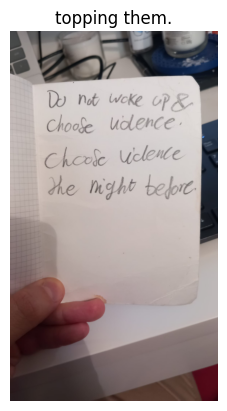

[handwriting_samples\WhatsApp Image 2025-09-03 at 16.29.21_c202bfca.jpg] -> 0 1


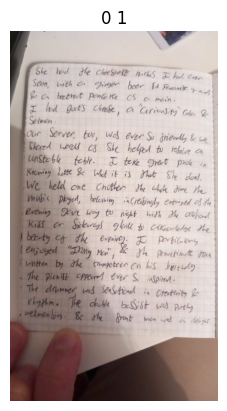


Saved predictions to trocr_predictions.csv


In [11]:
if __name__ == "__main__":
    # 3. Collect all PNG/JPEGs in folder
    image_dir = Path("handwriting_samples")  # put your images here
    image_paths = sorted(list(image_dir.glob("*.png")) + list(image_dir.glob("*.jpg")))

    if not image_paths:
        print("No images found in handwriting_samples/")
    else:
        # 4. Run OCR
        preds = ocr_images(image_paths, max_length=256)

        # 5. Save to CSV
        df = pd.DataFrame(preds)
        df.to_csv("trocr_predictions.csv", index=False)
        print("\nSaved predictions to trocr_predictions.csv")